# VIX Premium
Ing-Haw, Cheng, (2018), The Vix Premium

The author defines the vix premium as "the expected dollar loss for a long VIX futures contract with 1$ notional value held through expiration".

$$VIXP_{t}^T = E_{t}^Q[VIX_{T}]-E_{t}^P[VIX_{T}]$$

The VIX is the risk neutral expectation of realized variance over the next 30 days extracted from option prices such that:

$$VIX_{t} = \sqrt{E_{t}^Q[RV_{t,t+30}] }$$

So a VIX future expiring at time T is the risk neutral expectation at time t for VIX. That is why VIX futures are derivatives on a derivative.
The VIXP scaled for one month is given by:

$$\frac{21}{T(t)-t}[E_{t}^Q[VIX_{T(t)}]-E_{t}^P[VIX_{T(t)}]$$

Assuming no arbitrage the risk neutral expectation for VIX is given by the current futures contract:
$$F_{t}^{T(t)}=E_{t}^Q[VIX_{T}] $$
The conditional expectation for VIX  is estimated according to a baseline ARMA(2,2) model such that the VIXP is:
$$\frac{21}{T(t)-t}[F_{t}^{T(t)}-\widehat{VIX_{T(t)}}]$$
The author claims that VIXP falls or stays flat when conditional measures of risk increase. He attributes this to reduced hedging demand in periods of high risk. Furthermore the VIXP is a good predictor of VIX returns and falling VIXP predicts subsequent increases in market risk. He claims that this behavior creates profitable trading opportunities.

Evernote:https://www.evernote.com/shard/s20/nl/2254793/28c806fb-4650-43c9-86fc-282994a59a87/

In [1]:
from pathlib import Path   
import pandas as pd
import numpy as np
import pyfolio as pf
import pandas_datareader as web
from statsmodels.tsa.arima_model import ARMA

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as bbox
from matplotlib import rcParams
import seaborn as sns

import quandl
import nest_asyncio

import sys
import socket
opt_path = '/Users/ebellord/PycharmProjects/opt_trade'
if  opt_path not in sys.path:
    sys.path.append(opt_path)

if socket.gethostname() == 'edmunds-mbp.lan':
    %config InlineBackend.figure_format = 'retina'

from option_utilities import perf_stats, chart_format, PlotConstants
from option_simulation import OptionSimulation, plot_performance_quad, OptionTrades
from spx_data_update import UpdateSP500Data, ImpliedVolatilityHistory, \
    VixTSM, SP500Index, CBOEIndex
from implied_to_realized import SPX5MinuteBars
# from overlay_presentation import get_fund_assets

def table1_stats(df, name):
    out_series = df.describe().copy()
    out_series['First'], out_series['Last'] = [df.index[item].strftime('%b-%y') for item in [0, -1]]
    out_series = out_series.reindex(['count', 'First', 'Last', 'mean', 'std', 'min',
                                    'max', '50%'])
    return out_series.rename(name)

# Data

In [2]:
nest_asyncio.apply()
pc = PlotConstants()
vx = VixTSM()
vx_test = VixTSM()
iv_hist = ImpliedVolatilityHistory()
vix = iv_hist.implied_vol_index

vixp_d, vixp_m = [pd.read_excel(UpdateSP500Data.DATA_BASE_PATH / 'xl' / 'VIX_Premium.xlsx', 
                           sheet_name=sheet_name) for sheet_name in ['Daily', 'Monthly']]
vixp_d['dt'], vixp_m['dt'] = [df['dt'].apply(pd.to_datetime) for df in [vixp_d, vixp_m]]
vixp_d, vixp_m = [df.set_index('dt') for df in [vixp_d, vixp_m]]
vixp_d.index.name, vixp_m.index.name = [None for df in [vixp_d, vixp_m]] 

sp5 = SP500Index(update=False)
cboe = CBOEIndex()
bars = SPX5MinuteBars(update_bars=False)

# VIX - VIXP - VIXR Descriptive Statistics

INDEX
Average Monthly return: -3.75%
Annualize Vol: 59.93%
Sharpe: -0.75
Min: -30.00%
Max: 99.45%
Median: -6.87%


/Users/ebellord/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,count,First,Last,mean,std,min,max,50%
CBOE Volatility Index (VIX),141,Mar-04,Nov-15,19.573,8.76,10.42,59.89,16.74
VIX Futures return,119,May-04,Mar-14,-0.038,0.17,-0.30,0.99,-0.07
VIXP,140,Mar-04,Oct-15,0.706,1.42,-4.62,4.20,0.44
VIXR,140,Mar-04,Oct-15,-0.025,0.06,-0.14,0.10,-0.02
Realized Volatility,140,Apr-04,Nov-15,0.156,0.10,0.06,0.81,0.12
CBOE SKEW Index,141,Mar-04,Nov-15,120.182,5.84,106.43,139.35,120.13
CBOE VVIX Index,107,Jan-07,Nov-15,86.781,12.53,64.49,127.28,86.08
S&P 500 Excess,140,Apr-04,Nov-15,0.007,0.04,-0.17,0.11,0.01


/Users/ebellord/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


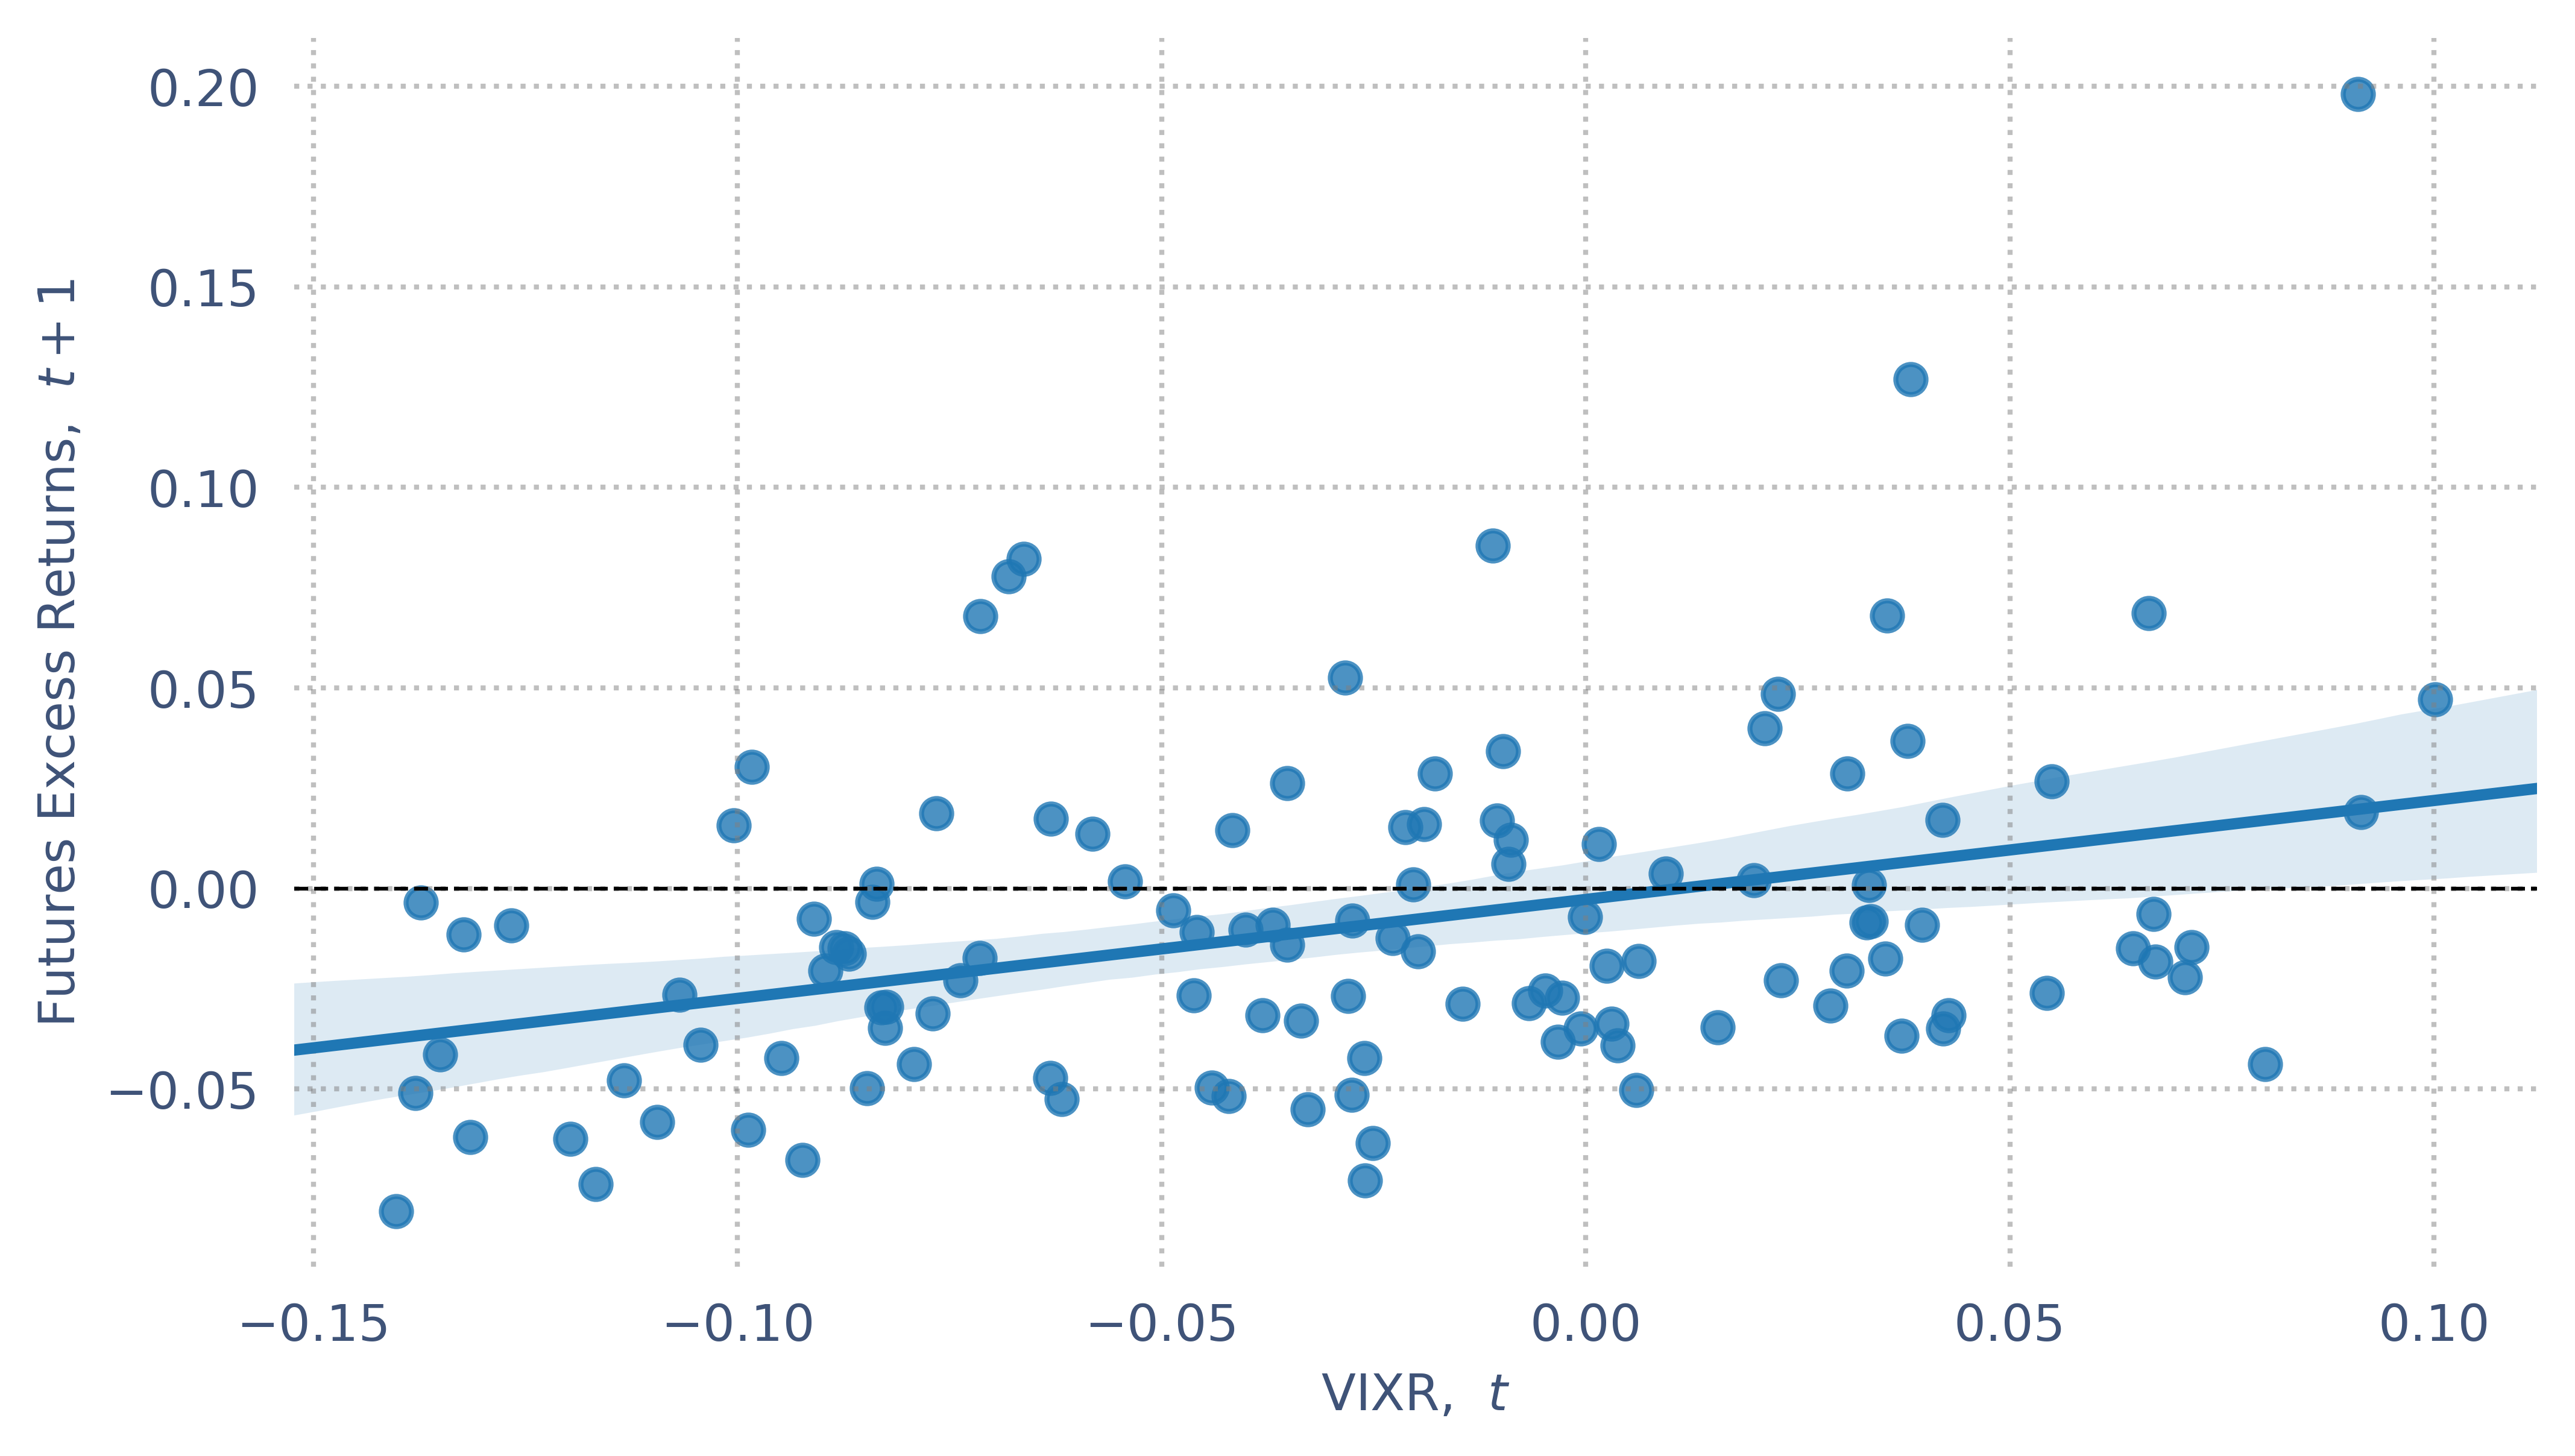

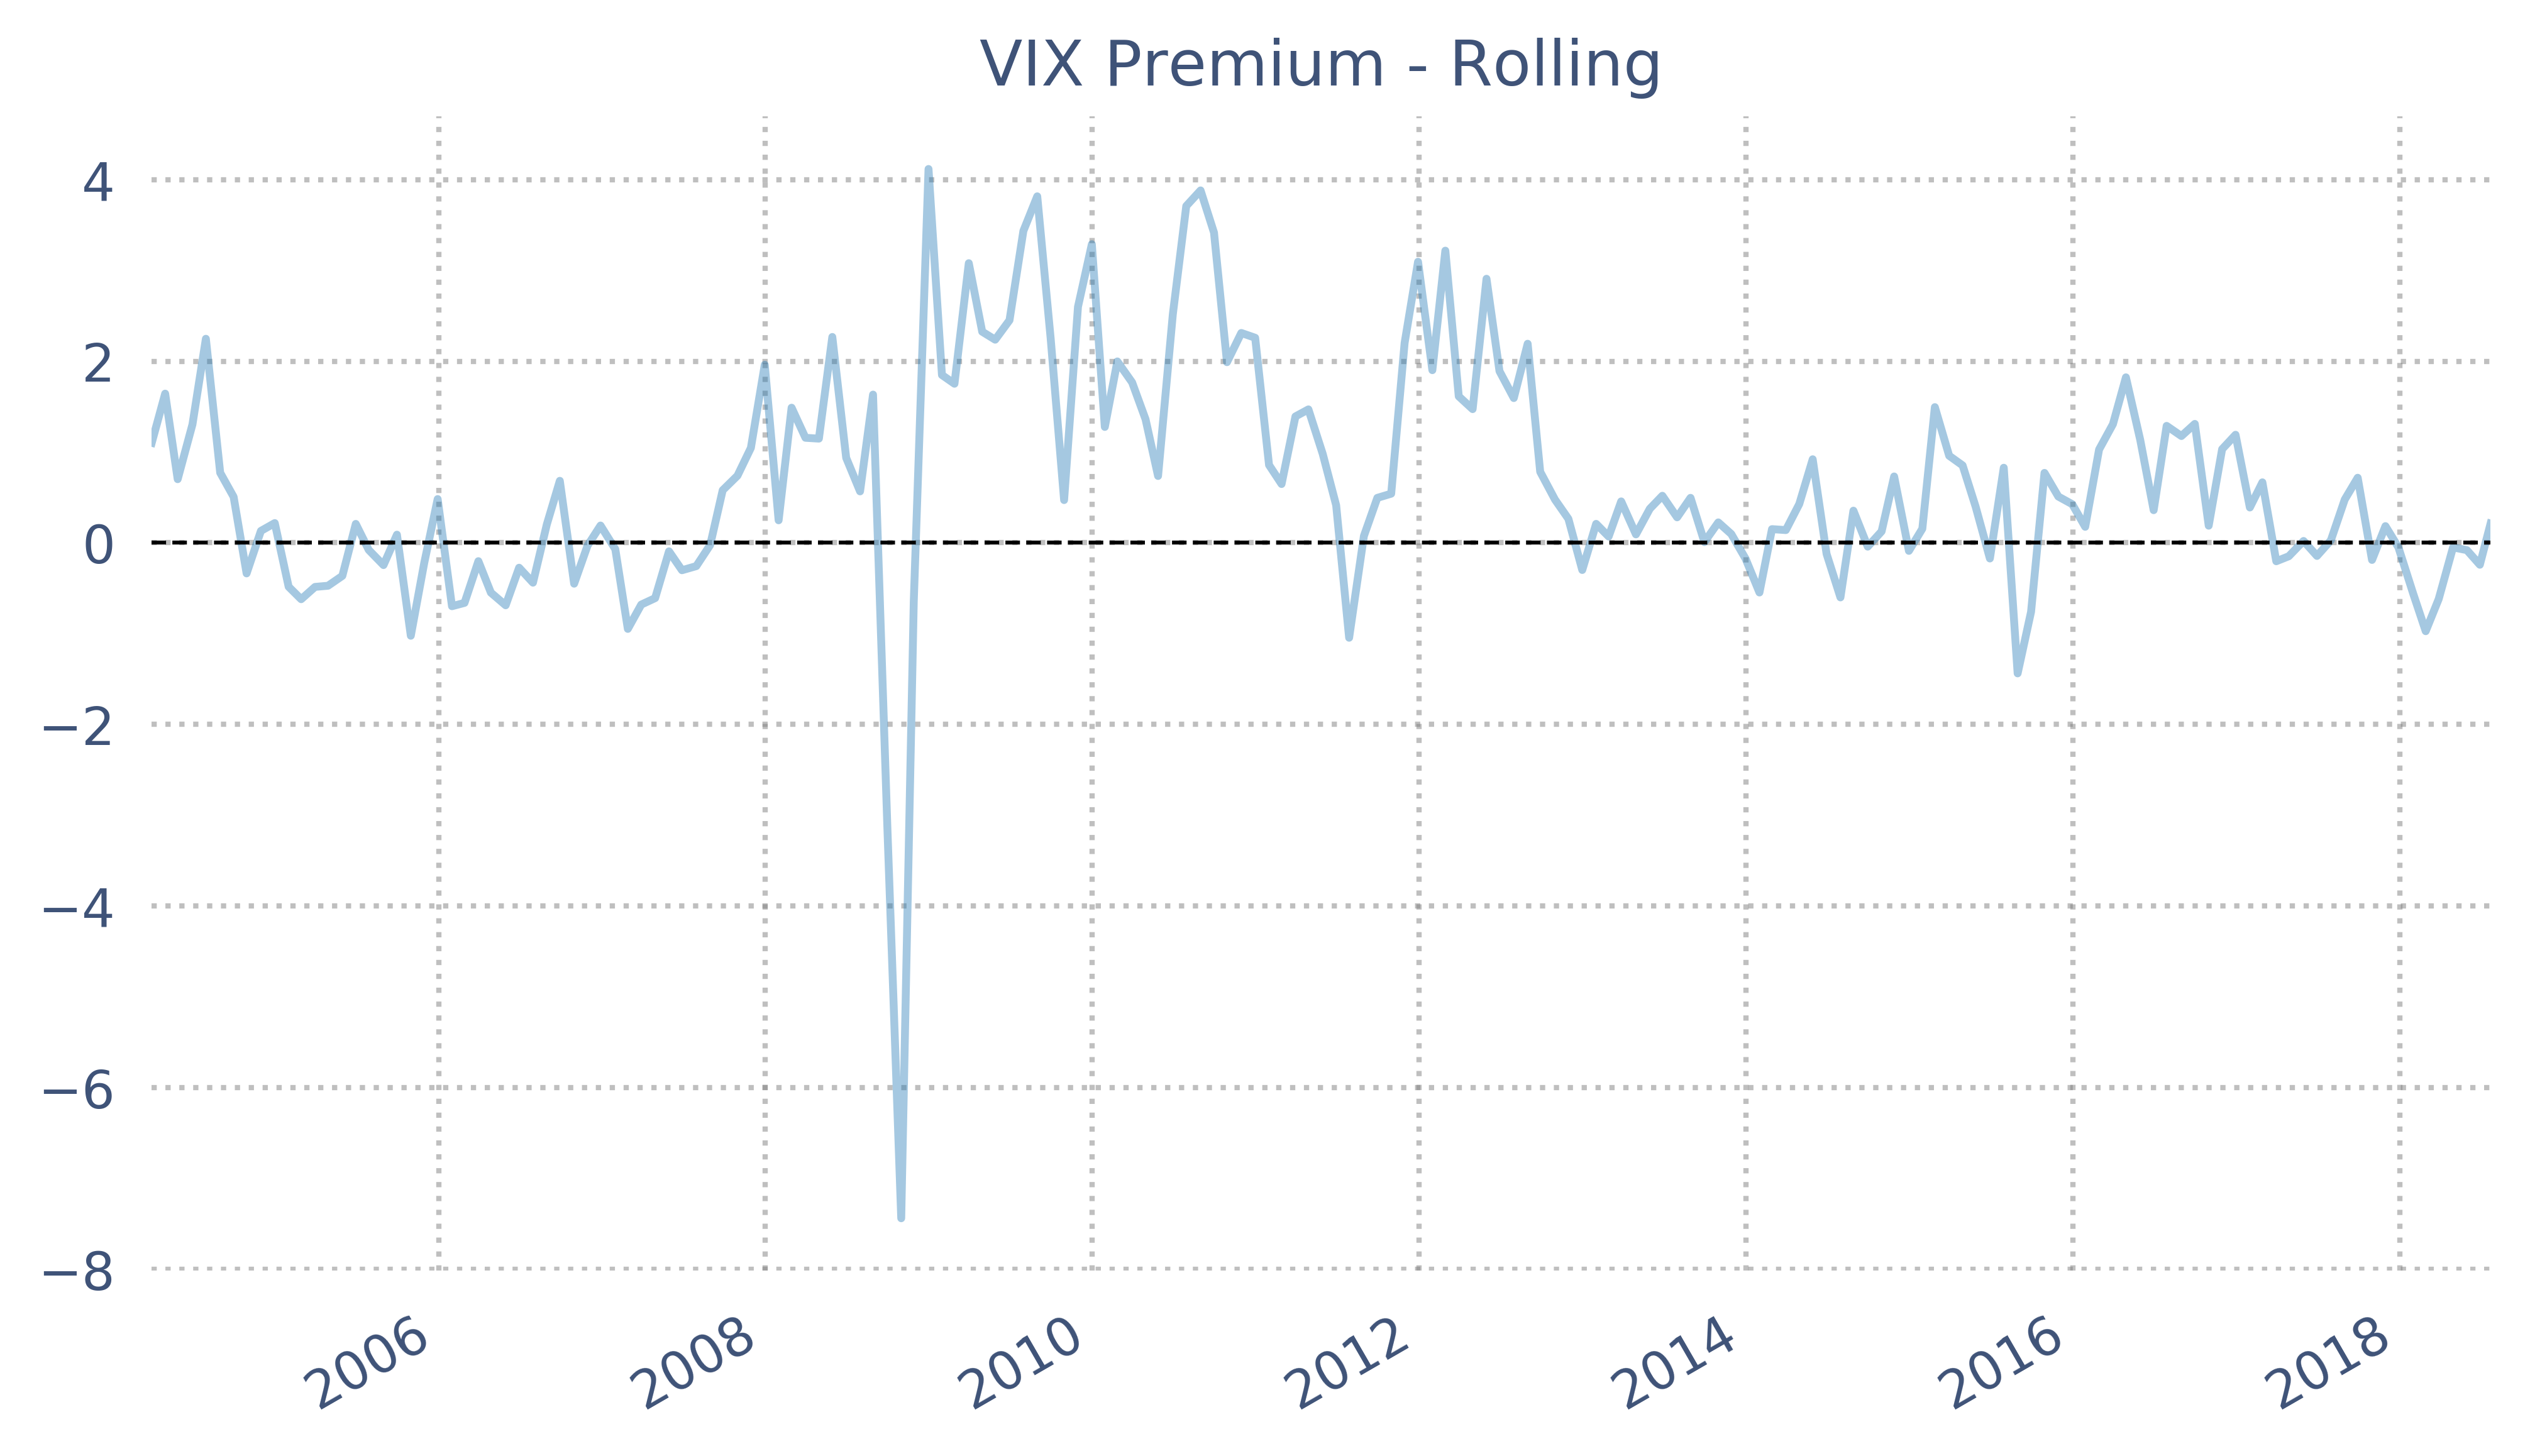

In [3]:
delever_constant = 4

vix_ret_monthly_col = vx.vix_idx_long.resample('BM',closed='left').ffill().pct_change().dropna(how='any').copy()
vix_fut_long_ret = vx.vix_ret_long.dropna(how='any').copy() / delever_constant
vix_fut_short_ret = vx.vix_ret_short.dropna(how='any').copy() / delever_constant

hand_crafted = True
if hand_crafted:
    hand_crafted_returns = pd.read_excel(UpdateSP500Data.DATA_BASE_PATH/ 'xl' / 'vixp_tsm_returns.xlsx', sheet_name='returns')
    hand_crafted_returns['Date'] = pd.to_datetime(hand_crafted_returns['Date'])
    hand_crafted_returns = hand_crafted_returns.set_index('Date')
    vix_fut_long_ret = hand_crafted_returns['FUT_RETURN'] / delever_constant
    vix_fut_long_idx = hand_crafted_returns['INDEX']
    vix_fut_short_idx = 1 / vix_fut_long_idx
    vix_fut_short_idx = vix_fut_short_idx / vix_fut_short_idx[0] * 100
    vix_ret_monthly_col = vix_fut_long_idx.resample('BM',closed='left').ffill().pct_change().dropna(how='any').copy()
    vix_fut_short_ret = vix_fut_short_idx.pct_change().dropna(how='any') / delever_constant
    vix_fut_short_ret = vix_fut_short_ret.rename('short_front')
    vix_fut_long_ret = vix_fut_long_ret.rename('long_front')

for item in [vix_ret_monthly_col]:
    print(item.name)
    print('Average Monthly return: {:0.2f}%'.format(item.mean()*100))
    print('Annualize Vol: {:0.2f}%'.format(item.std() * np.sqrt(12) *100))
    print('Sharpe: {:0.2f}'.format((item.mean() * 12 ) / (item.std() * np.sqrt(12))))   
    print('Min: {:0.2f}%'.format(item.min()*100))
    print('Max: {:0.2f}%'.format(item.max()*100))
    print('Median: {:0.2f}%'.format(item.median()*100))
    
vixp_mm = vixp_m['vixr_2004'].resample('BM', closed='left').ffill()
vix_fut_long_idx = pf.timeseries.cum_returns(vix_fut_long_ret, 100)
vix_fut_long_idx_m = vix_fut_long_idx.resample('BM', closed='left').ffill()
vix_fut_long_ret_m = vix_fut_long_idx_m.pct_change().dropna(how='any')
vix_fut_long_ret_m = vix_fut_long_ret_m.rename('Long VIX futures')
vixp_mm_lag = vixp_mm.shift(1).dropna(how='any')

plot_data = pd.concat([vix_fut_long_ret_m, vixp_mm_lag], axis=1).dropna(how='any')
x = vixp_mm_lag.name
y = vix_fut_long_ret_m.name
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')

gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_scat = plt.subplot(gs[:])
ax_plot = sns.regplot(x, y, data=plot_data)
ax_scat.axhline(0,
             color='k',
             ls='--',
             lw=0.75,
             alpha=1.0)
ax_scat.set_ylabel('Futures Excess Returns, $\ {t+1}$')
ax_scat.set_xlabel('VIXR, $\ t$')
chart_format([ax_scat],pc.color_light)

plt.autoscale(enable=True,
              axis='x',
              tight=True)


realized_vol = np.sqrt(bars.realized_variance * 12)
table1 = pd.concat([table1_stats(vix['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                                 'CBOE Volatility Index (VIX)'),
#                     table1_stats(vx.contract_values.resample('BM', closed='left').ffill().dropna(how='any'), 'VIX Futures prices'),
                    table1_stats(vix_ret_monthly_col, 'VIX Futures return'),
                    table1_stats(vixp_m['vixp_2004'].dropna(how='any'), 'VIXP'),
                    table1_stats(vixp_m['vixr_2004'].dropna(how='any'), 'VIXR'),
                    table1_stats(realized_vol['02-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                                 'Realized Volatility'),
                    table1_stats(cboe.skew['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                               'CBOE SKEW Index'),
                    table1_stats(cboe.vvix['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                               'CBOE VVIX Index'),
                    table1_stats(sp5.return_index['03-2004':'11-2015'].resample('BM', closed='left').ffill().pct_change().dropna(how='any'),
                                'S&P 500 Excess'),], axis=1)


display(table1.transpose().style.format({'mean': '{:,.3f}', 'std': '{:,.2f}', 'min': '{:,.2f}',
                                    'max': '{:,.2f}', '50%': '{:,.2f}'}))
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_vixp = plt.subplot(gs[:])
ax_vixp = vixp_m['vixp_rolling'].plot(lw=1.5,
                                    ax=ax_vixp, 
                                    grid=True,
                                    alpha=0.4,
                                    title ='VIX Premium - Rolling')
ax_vixp.axhline(0,
             color='k',
             ls='--',
             lw=0.75,
             alpha=1.0)
chart_format([ax_vixp],pc.color_light)

plt.autoscale(enable=True,
              axis='x',
              tight=True)



# Daily VIX Premium strategy
Simple trading strategy that goes short rolling VIX futures when VIXP is positive and goes short same when VIXP is negative

,L/S,S/-,L/-,short_front,long_front,S&P 500
StartDate,"Apr 05, 2004","Apr 05, 2004","Apr 05, 2004","Apr 06, 2004","Apr 05, 2004","Apr 06, 2004"
EndDate,"Apr 03, 2014","Apr 03, 2014","Apr 03, 2014","Apr 03, 2014","Apr 03, 2014","Apr 04, 2014"
annual_return,0.217233,0.198658,0.0154968,0.204,-0.11867,0.071573
annual_volatility,0.141063,0.114293,0.0828484,0.139549,0.14165,0.204133
sharpe_ratio,1.46469,1.64341,0.226723,1.40093,-0.82127,0.440943
calmar_ratio,1.02008,1.27869,0.0646075,0.656595,-0.163869,0.129543
stability_of_timeseries,0.929637,0.935776,0.719671,0.936587,-0.867433,0.618424
max_drawdown,-0.212956,-0.15536,-0.23986,-0.310694,-0.724177,-0.552502
omega_ratio,1.30059,1.40071,1.08592,1.28295,0.862752,1.09108
sortino_ratio,2.26135,2.46064,0.37409,2.02794,-1.22748,0.619094


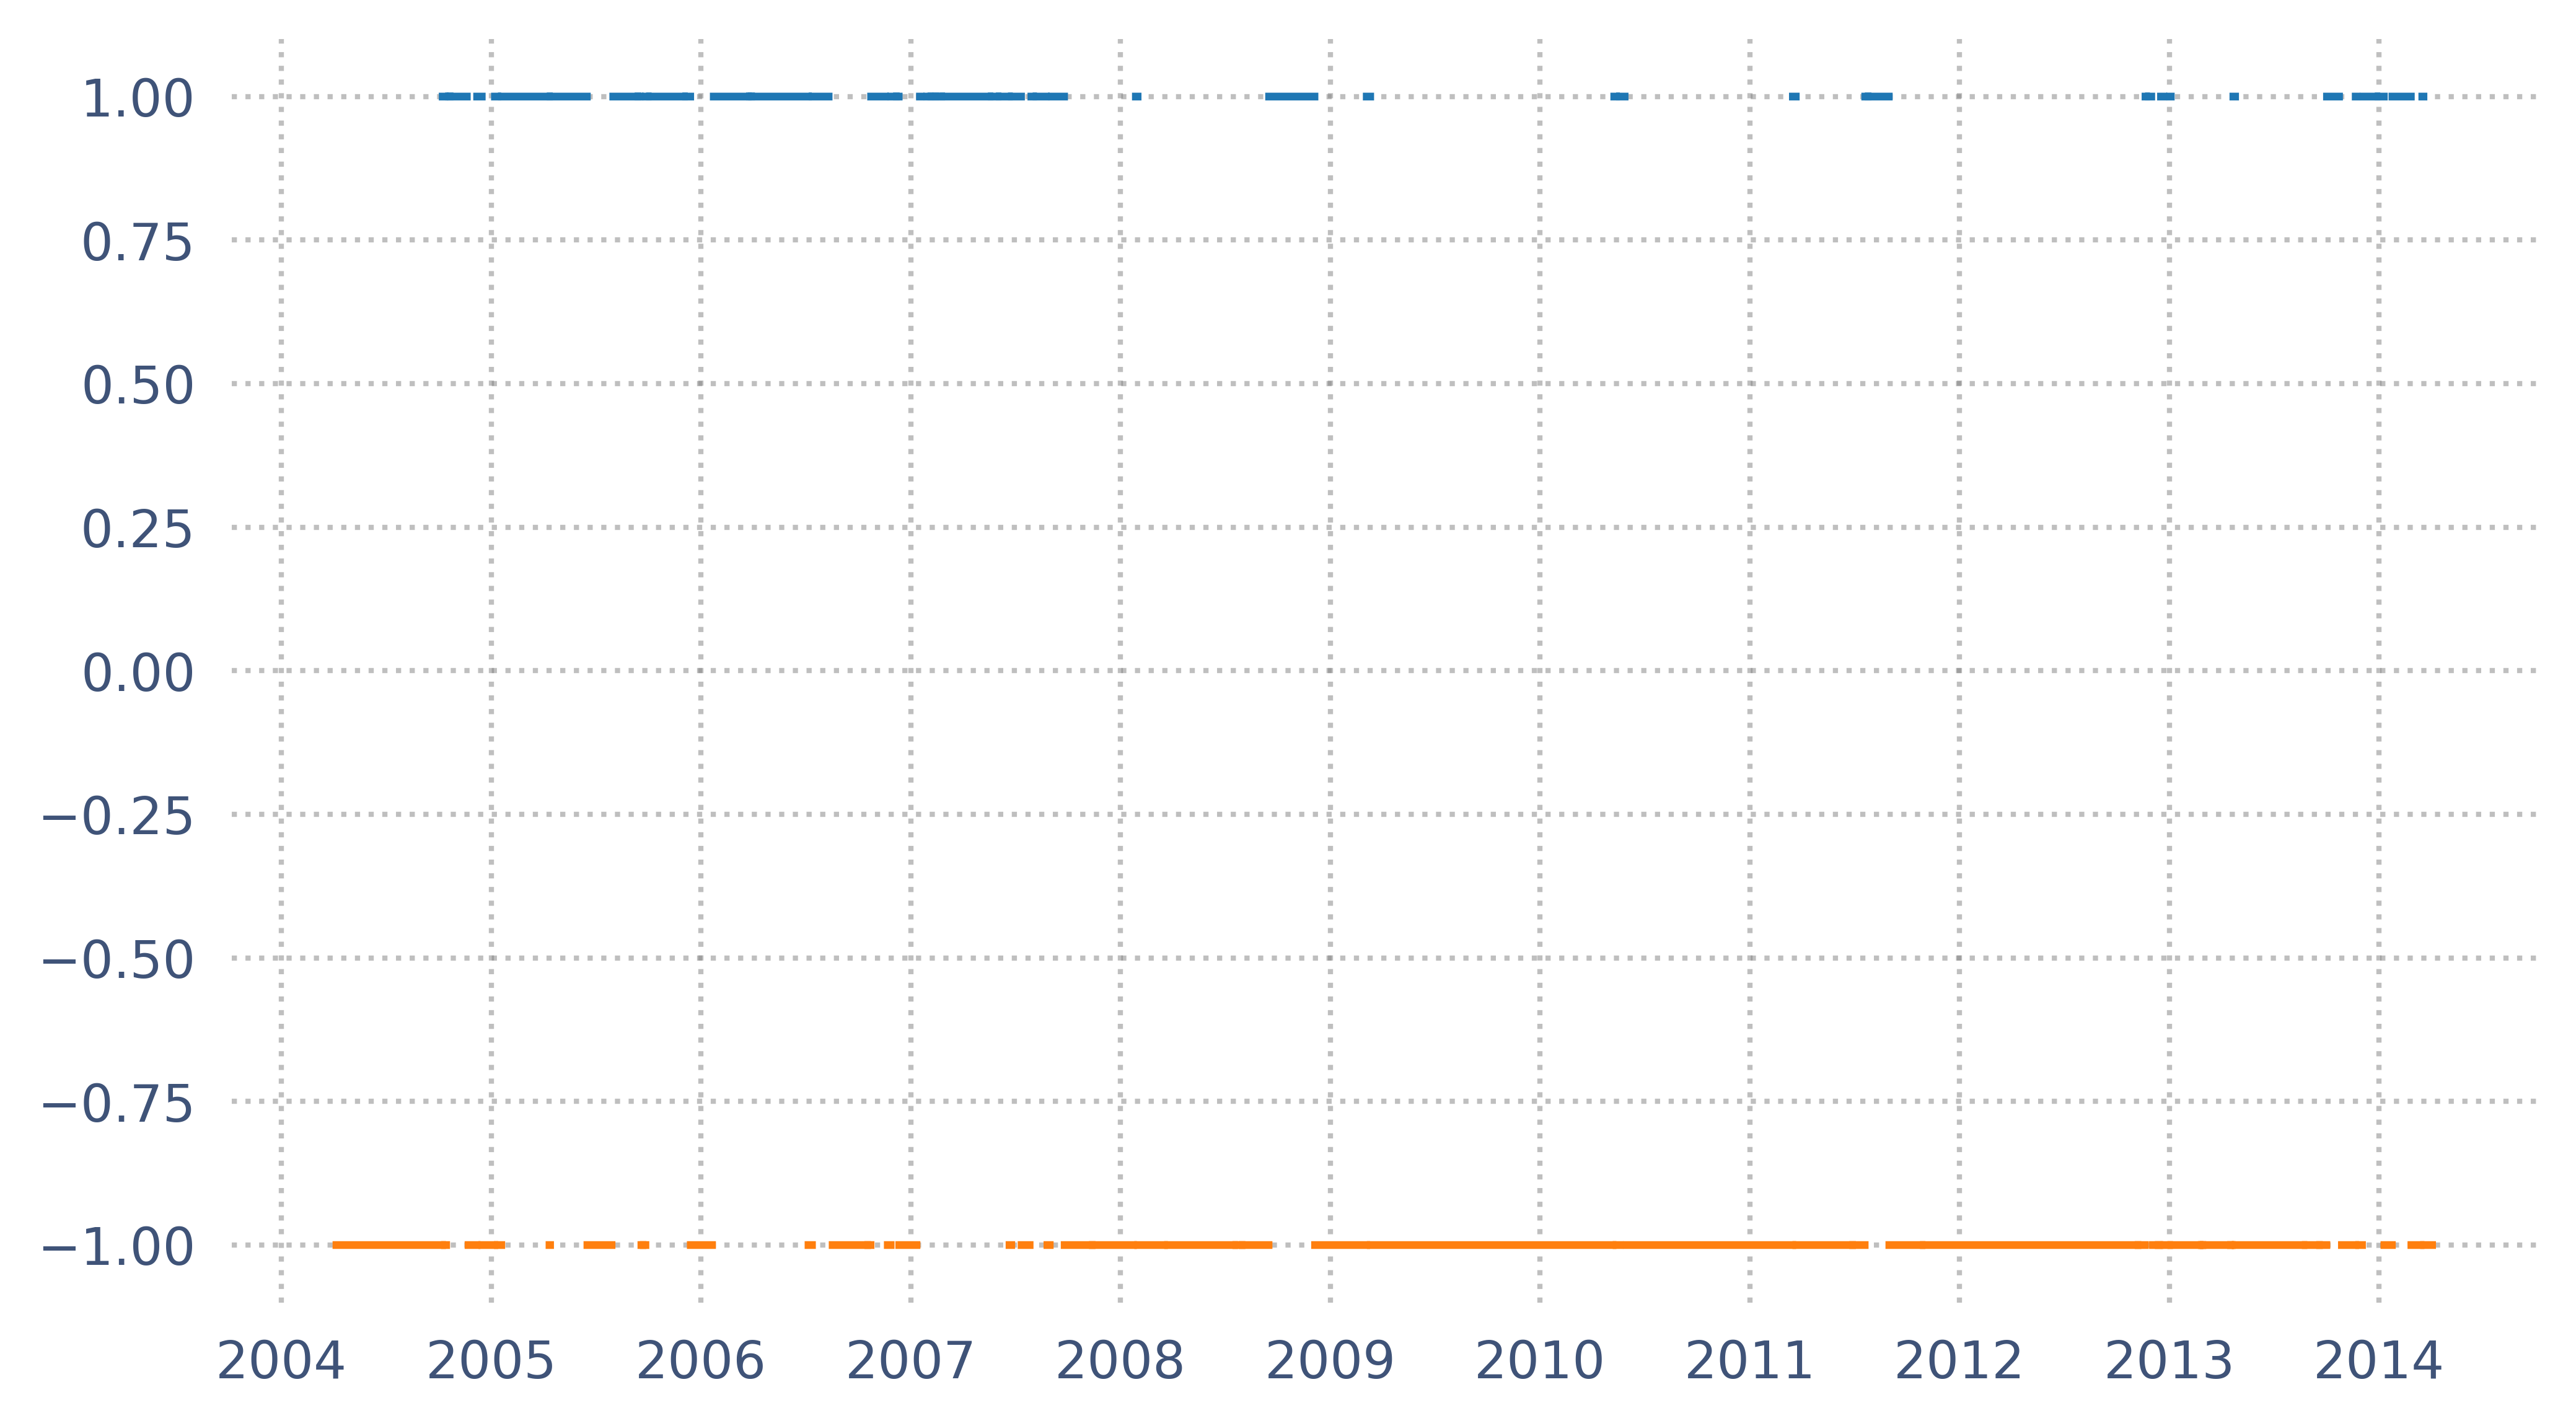

In [4]:
vixp_signal = vixp_d['vixr_rolling'].shift(1).dropna(how='any')

# foo = vixp_signal.resample('BM', closed='left').ffill()
# vixp_signal = foo.reindex(vixp_signal.index).ffill()

vixp_signal = vixp_signal.reindex(vix_fut_short_ret.index)
short_signal = vixp_signal < 0
long_signal = ~short_signal
signal_ret = pd.concat([short_signal.astype(int) * vix_fut_short_ret, 
                   long_signal.astype(int) * vix_fut_long_ret], axis=1)
signal_ret['L/S'] = signal_ret.sum(axis=1)
signal_ret = signal_ret.rename(columns={0:'S/-', 1:'L/-'})

display(pd.concat([perf_stats(signal_ret['L/S']),
           perf_stats(signal_ret['S/-']),
           perf_stats(signal_ret['L/-']),
           perf_stats(vix_fut_short_ret),
           perf_stats(vix_fut_long_ret),
           perf_stats(sp5.return_index['04-05-2004':'04-04-2014'].pct_change().dropna(how='any'))], axis=1))
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_pos = plt.subplot(gs[:])
short_weight = - short_signal.astype(int)
short_weight = short_weight.replace(0, np.nan)
long_weight = long_signal.astype(int)
long_weight = long_weight.replace(0, np.nan)
_ = plt.plot(long_weight)
_ = plt.plot(short_weight)
chart_format([ax_pos], pc.color_light)


# S&P 500 Beta Hedge

In [ ]:
sp5_idx = sp5.excess_return_index[vixp_signal.index]
sp5_idx_short = 1 / sp5_idx
beta = 0.75
sp5_ret_long, sp5_ret_short = [item.pct_change() * beta for item in [sp5_idx, sp5_idx_short]]
hedge_ret = pd.concat([short_signal.astype(int) * sp5_ret_short, long_signal.astype(int) * sp5_ret_long], axis=1)
hedge_ret['Beta_hedge'] = hedge_ret.sum(axis=1)
hedged_strategy_ret = hedge_ret['Beta_hedge'] + signal_ret['L/S']
hedged_strategy_ret = hedged_strategy_ret.rename('L/S_hedge')
display(pd.concat([perf_stats(hedged_strategy_ret), 
           perf_stats(signal_ret['L/S']),
           perf_stats(hedge_ret['Beta_hedge'])], axis=1))
hedged_strategy_idx = pf.timeseries.cum_returns(hedged_strategy_ret, 100)
hedged_strategy_idx_log = np.log(hedged_strategy_idx)
hedged_strategy_idx_log = hedged_strategy_idx_log / hedged_strategy_idx_log[0]
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_hed = plt.subplot(gs[:])
_ = hedged_strategy_idx_log.plot(lw=1.5,
                            ax=ax_hed, 
                            grid=True,
                            alpha=0.4,
                            title ='Hedged Strategy')

chart_format([ax_hed],pc.color_light)

plt.autoscale(enable=True,
              axis='x',
              tight=True)
_ = plot_performance_quad(hedged_strategy_ret)
_ = plot_performance_quad(signal_ret['L/S'])
display(pf.timeseries.gen_drawdown_table(hedged_strategy_ret, pc.font_size))


# Add Put Selling program & cash

In [ ]:
opt_sim = OptionSimulation(update_simulation_data=True)
z_score = -1
duration = 2
leverage = 2
sim_idx = 0
%time sim_output = [opt_sim.trade_sim(z_score, duration, trade_day_type=day_type) \
                    for day_type in ['EOM']]
opt_trade = [OptionTrades(sim, leverage=leverage) for sim in sim_output]

shared_dates = hedged_strategy_ret.index.intersection(opt_trade[0].returns.index)
total_port = hedged_strategy_ret[shared_dates] + opt_trade[0].returns[shared_dates]
total_port_idx = pf.timeseries.cum_returns(total_port, 100)


cash = opt_sim.usZeroYldCurve.cash_index[total_port_idx.index]
total_port_idx = total_port_idx * cash
total_port_idx = total_port_idx / total_port_idx[0] * 100
total_port_idx_log = np.log(total_port_idx)
total_port_idx_log = total_port_idx_log / total_port_idx_log[0] * 100

total_port = total_port_idx.pct_change().dropna(how='any')
total_port = total_port.rename('VixP/Overlay/Cash')
display(pd.concat([hedged_strategy_ret[shared_dates],
                   opt_trade[0].returns[shared_dates],
                  sp5.return_index.pct_change()[shared_dates],
                  total_port[shared_dates]], axis=1).corr())
plot_performance_quad(total_port)
display(pd.concat([perf_stats(hedged_strategy_ret[total_port.index]),
                   perf_stats(opt_trade[0].returns[total_port.index]),
                   perf_stats(total_port)], axis=1))

fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_total = plt.subplot(gs[:])
ax_total = total_port_idx_log.plot(lw=1.5,
                            ax=ax_total, 
                            grid=True,
                            alpha=0.4,
                            title ='Hedged Strategy')

chart_format([ax_total], pc.color_light)
plt.autoscale(enable=True,
              axis='x',
              tight=True)
display(pf.timeseries.gen_drawdown_table(total_port))



In [ ]:

# model = ARMA(VIX['1990':'2003'], order=(2,2))
# model_fit = model.fit(disp=0)
# print(model_fit.summary())VIX['1990':'2003']

# X = VIX.values
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = []
# for t in range(len(test)):
#     model = ARMA(history, order=(2,2))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast(steps=34)
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)

#     print('predicted=%f, expected=%f' % (yhat[-1], obs))

In [ ]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

vixp_dates = pd.to_datetime(vixp_d['contract_dt'])
contract_dates = []
date_list = pd.to_datetime(vx.raw_tsm_df['exp1'].dropna().astype(int), format='%Y%m%d')
for dts in vixp_dates:
    contract_dates.append(nearest(date_list, dts))

In [ ]:
vixp_signal = vixp_signal.reindex(vix_fut_short_ret.index)
vixp_signal
short_signal = vixp_signal < 0
long_signal = ~short_signal
signal_ret = pd.concat([short_signal.astype(int) * vix_fut_short_ret, 
                   long_signal.astype(int) * vix_fut_long_ret], axis=1)
# signal_ret['L/S'] = signal_ret.sum(axis=1)
# signal_ret = signal_ret.rename(columns={0:'S/-', 1:'L/-'})
vix_fut_short_ret

In [ ]:
vx.raw_tsm_df['close1'].pct_change()
# vx.vix_ret_long